In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from orbitize import results, plot
from astropy import units as u, constants as cst
from astropy.time import Time

# load results
run_name = "planetTrue_dvdFalse_renormHIPFalse_burn100_total50000000"
beetle_results = results.Results()
beetle_results.load_results("results/{}.hdf5".format(run_name))

# create new dir for plots about this run
savedir = "plots/{}".format(run_name)
if not os.path.exists(savedir):
    os.mkdir(savedir)

# TODO: run a longer fit to make sure it's converged.

/home/sblunt/orbitize/orbitize/hipparcos.py:226: SyntaxWarning: invalid escape sequence '\s'
  path_to_iad_file, skiprows=9, sep="\s+", nrows=1
/home/sblunt/orbitize/orbitize/hipparcos.py:240: SyntaxWarning: invalid escape sequence '\s'
  path_to_iad_file, skiprows=5, sep="\s+", nrows=1


Make corner plot, secondary mass plot, and period plot:

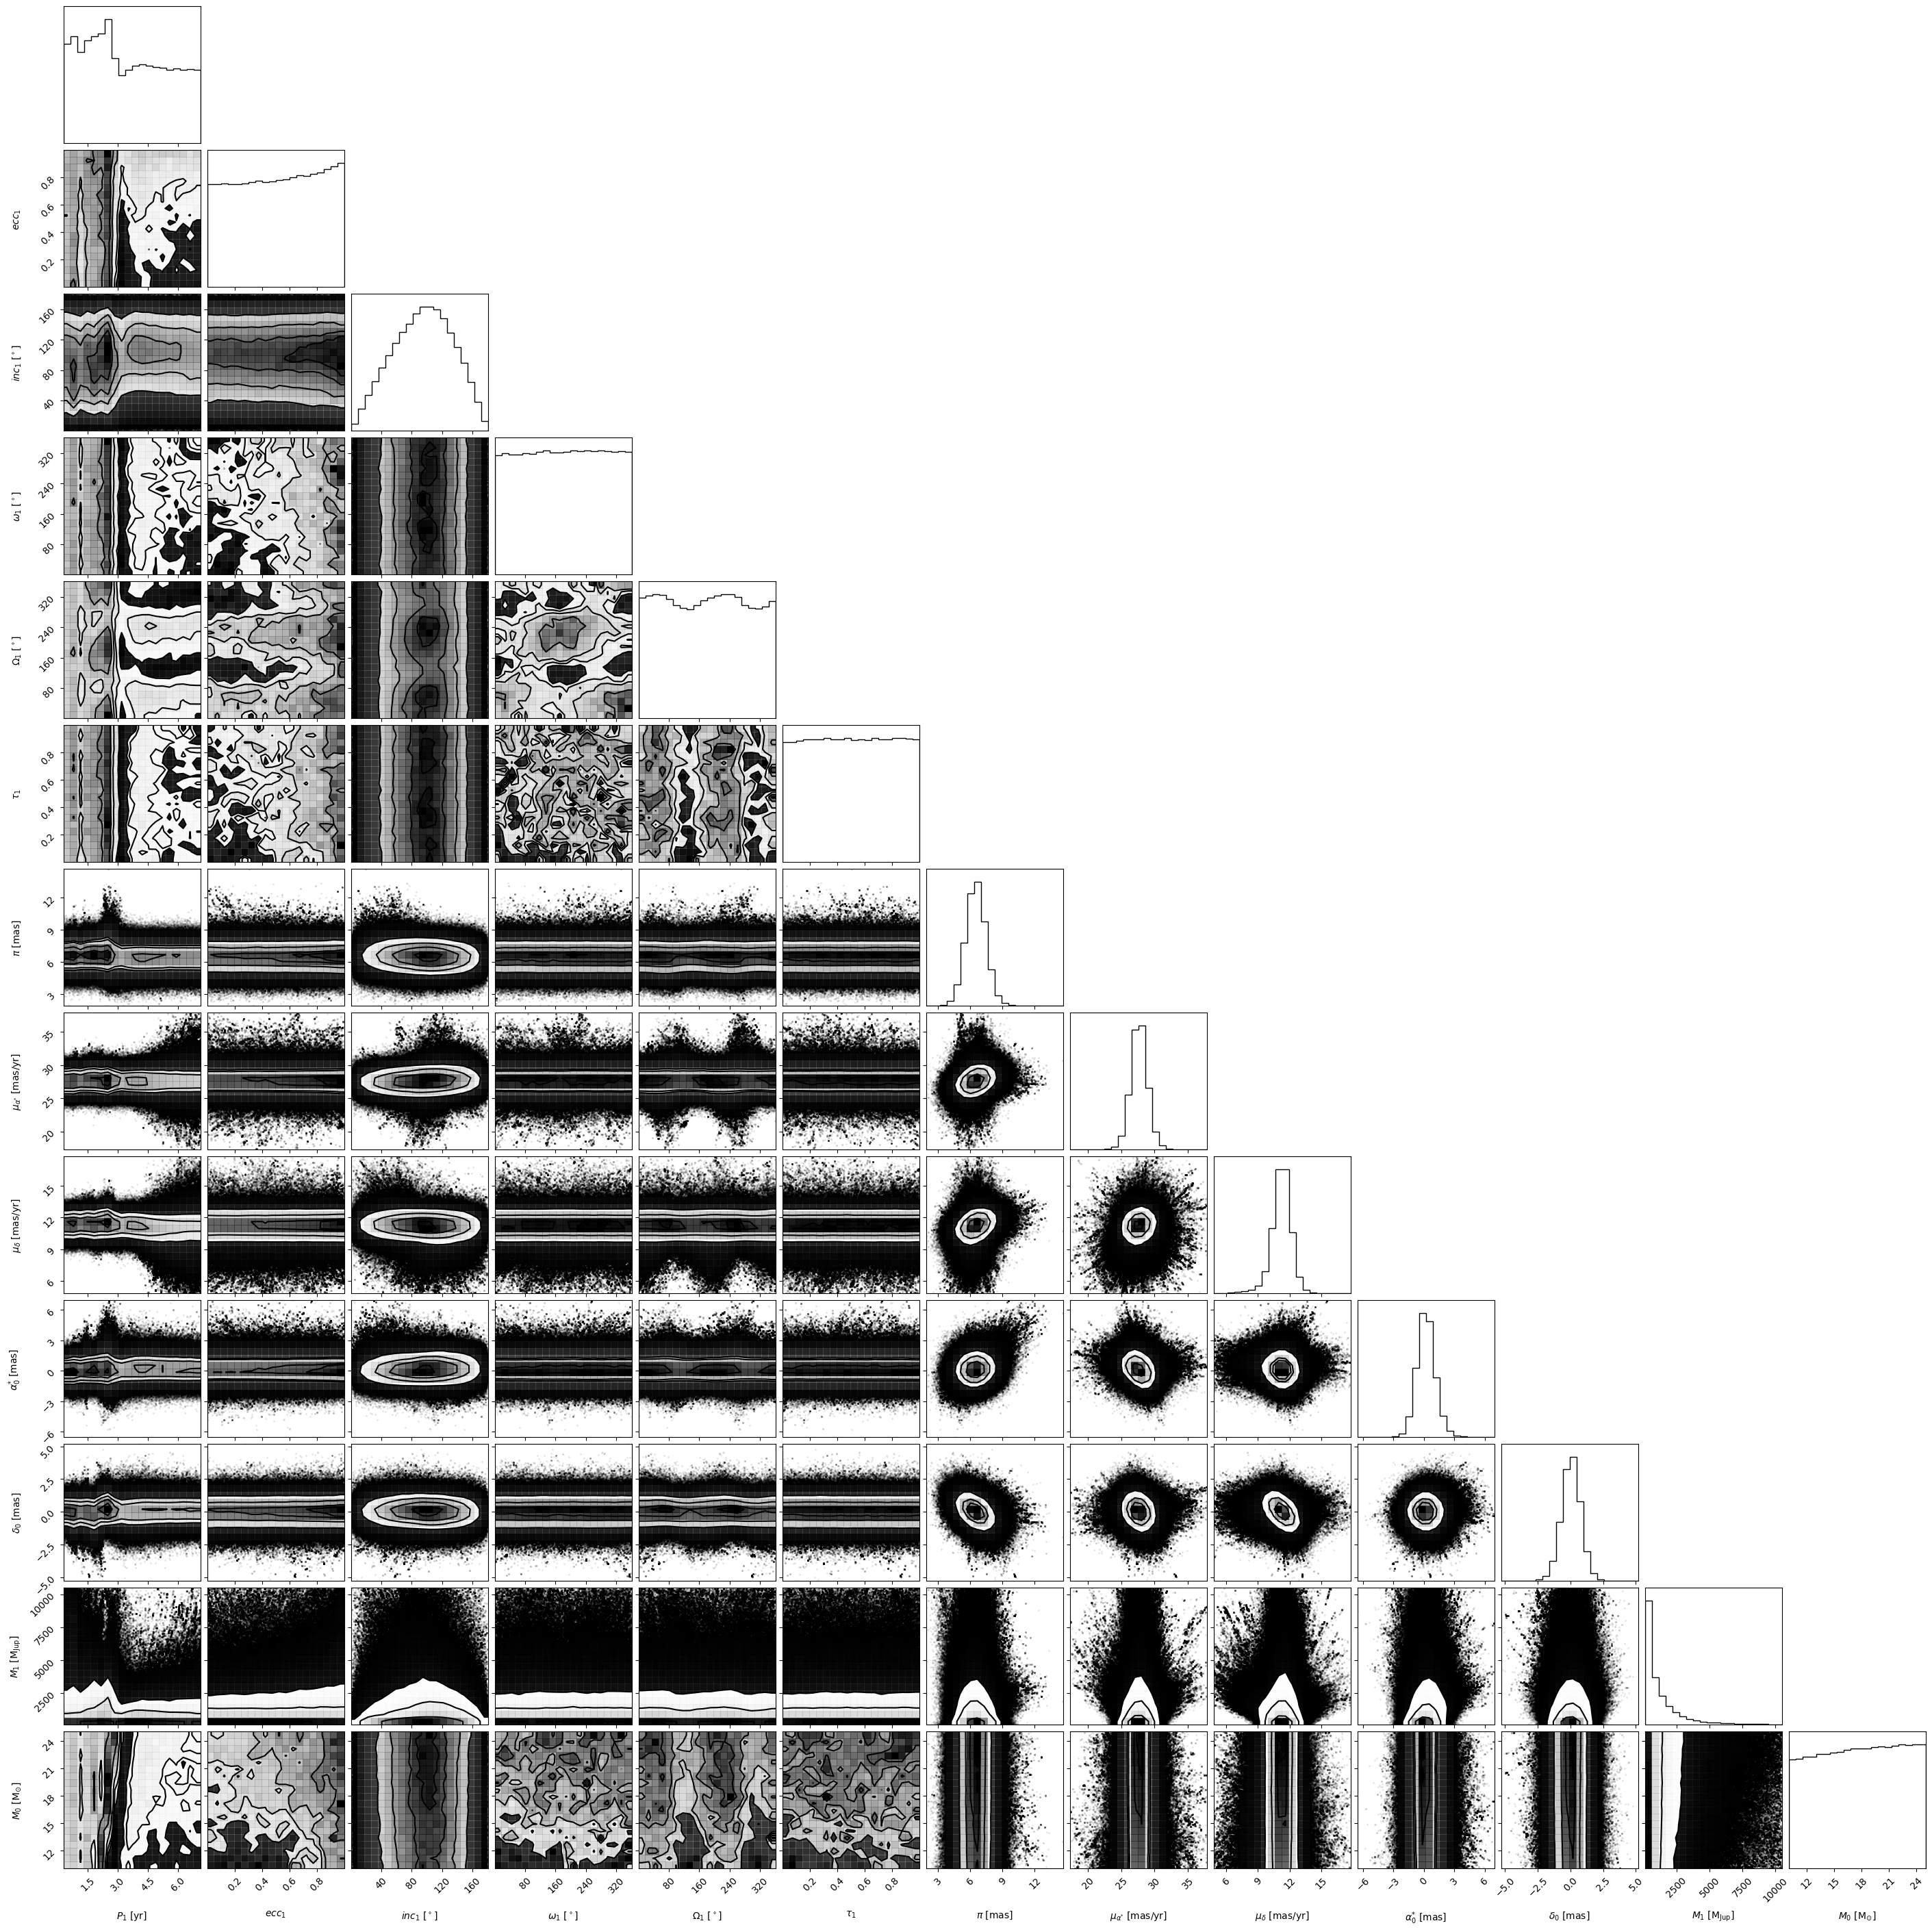

In [3]:
plot.plot_corner(beetle_results)
plt.savefig("{}/corner.png".format(savedir), dpi=250)

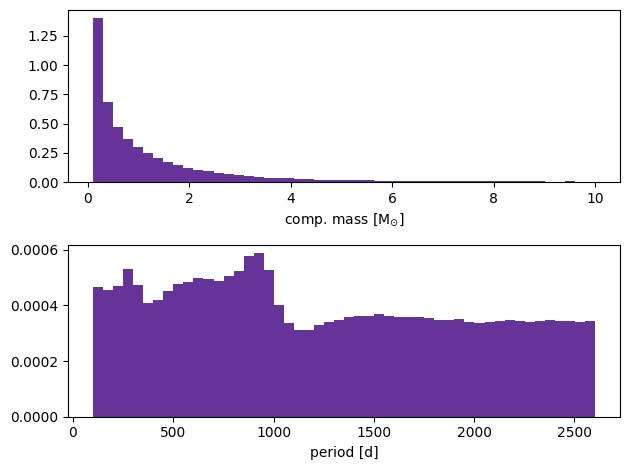

In [2]:
fig, ax = plt.subplots(2, 1)
ax[0].hist(
    beetle_results.post[:, beetle_results.param_idx["m1"]] * u.M_jup / u.M_sun,
    bins=50,
    density=True,
    color="rebeccapurple",
)
ax[0].set_xlabel("comp. mass [M$_{{\\odot}}$]")
ax[1].hist(
    beetle_results.post[:, beetle_results.param_idx["per1"]] * 365.25,
    bins=50,
    density=True,
    color="rebeccapurple",
)
ax[1].set_xlabel("period [d]")
plt.tight_layout()
plt.savefig("{}/mass_period.png".format(savedir), dpi=250)

Compute amplitude of astrometric signal & goodness-of-fit:

In [ ]:
# calculate magnitude of astrometric signal over a single orbital period
# TODO

fig, ax = plt.subplots(1, 1)

# TODO: compute goodness-of-fit
# TODO: compute WAIC & compare to 1-body fit

Visualize the fit:

In [ ]:
# make a plot with showing the star's total motion
fig, ax = plt.subplots()

# TODO: add Hipparcos IAD to this figure

plt.errorbar(
    beetle_results.system.data_table["quant1"],
    beetle_results.system.data_table["quant2"],
    yerr=beetle_results.system.data_table["quant2_err"],
    xerr=beetle_results.system.data_table["quant1_err"],
    ls="",
    color="purple",
)
plt.xlabel("$\Delta\\alpha$cos($\delta_0$) [mas]")
plt.ylabel("$\Delta\\delta$ [mas]")

# pick some random orbits from the posterior
num2plot = 100
plot_indices = np.random.randint(0, len(beetle_results.post), size=num2plot)

epochs2plot = np.linspace(
    np.min(beetle_results.system.data_table["epoch"]),
    np.max(beetle_results.system.data_table["epoch"]),
    int(1e3),
)

raoff_orbit, deoff_orbit, _ = beetle_results.system.compute_all_orbits(
    beetle_results.post[plot_indices].T,
    epochs2plot,
)
print(beetle_results.post[plot_indices[0]])
print(beetle_results.system.param_idx)

for i in np.arange(num2plot):
    (
        raoff_pmplx,
        deoff_pmplx,
    ) = beetle_results.system.pm_plx_predictor.compute_astrometric_model(
        beetle_results.post[plot_indices[i]], beetle_results.system.param_idx
    )
    print(raoff_pmplx)
    # plt.plot(raoff[:, 0, i], deoff[:, 0, i])

# make a plot showing 100 random tracks of the orbit motion (two panel: RA & Dec) vs time
# overplot same 100 error bars with PM & plx subtracted (renormalize?)

Compare orbital phase of RV and astrometric orbits:

In [ ]:
from orbitize.basis import tau_to_tp
from radvel.basis import timeperi_to_timetrans


tau_post = beetle_results.post[:, beetle_results.param_idx["tau1"]]
per_post = beetle_results.post[:, beetle_results.param_idx["per1"]]
ecc_post = beetle_results.post[:, beetle_results.param_idx["ecc1"]]
aop_pl_post = beetle_results.post[:, beetle_results.param_idx["aop1"]]
pan_post = beetle_results.post[:, beetle_results.param_idx["pan1"]]
aop_st_post = aop_pl_post + np.pi
per_post_days = per_post * 365.25

match_per_mask = (per_post_days > 2000) & (per_post_days < 2500)

tP_post = tau_to_tp(tau_post, beetle_results.tau_ref_epoch, per_post)
tC_post = timeperi_to_timetrans(tP_post, per_post_days, ecc_post, aop_st_post)


after_date = after_date = Time(2018, format="decimalyear").mjd
num_periods = (after_date - tC_post) / per_post_days
num_periods = np.ceil(num_periods).astype(int)
tC_post += num_periods * per_post_days

fig, ax = plt.subplots(1, 1)
ax.hist(
    Time(tC_post, format="mjd").decimalyear,
    bins=50,
    color="rebeccapurple",
    label="all P",
    density=True,
)
# ax.hist(
#     Time(tC_post[match_per_mask], format="mjd").decimalyear,
#     bins=50,
#     color="pink",
#     histtype="step",
#     label="2000 d < P < 2500 d",
# )
ax.hist(
    Time(
        tC_post[match_per_mask & (np.degrees(pan_post) > 150)], format="mjd"
    ).decimalyear,
    bins=50,
    color="hotpink",
    histtype="step",
    label="2000 d < P < 2500 d AND $\\Omega_{{*}}$ ~ 50deg",
    density=True,
)
ax.legend()
ax.set_xlabel("first time of conj. after 2018 [yr]")
plt.savefig("{}/phase.png".format(savedir), dpi=250)

Compare the orbital angular momentum vector orientation with the star's:

In [ ]:
from scipy.stats import norm


def cos_i_mutual(orb_inc, st_inc, orb_pan, st_pan):
    """
    Ref: De Rosa, Dawson, Nielsen 2020, eq 24
    """
    return np.cos(orb_inc) * np.cos(st_inc) + np.sin(orb_inc) * np.sin(st_inc) * np.cos(
        orb_pan - st_pan
    )


inc_post = beetle_results.post[:, beetle_results.param_idx["inc1"]]
pan_post = beetle_results.post[:, beetle_results.param_idx["pan1"]]


# mutual_inc_posterior = cos_i_mutual(inc_post, st_inc, pan_post, st_pan)

"""
Ref for PAN of Betelgeuse:
https://www.aanda.org/articles/aa/full_html/2018/01/aa31761-17/T4.html
"""

beetle_rot_pan = [
    (48.0, 1.1),
    (47.6, 1.1),
    (49.5, 1.0),
    (47.9, 1.0),
    (51.9, 1.3),
    (50.6, 1.0),
    (45.5, 1.0),
    (45.8, 1.0),
]

fig, ax = plt.subplots(2, 1)
ax[0].hist(np.degrees(inc_post), bins=50, color="rebeccapurple", density=True)
ax[0].axvline(90, color="hotpink", ls="-.", label="edge on")
ax[0].legend()
ax[1].hist(np.degrees(pan_post) % 180, bins=50, color="rebeccapurple", density=True)

xs = np.linspace(25, 60, 200)
for i, (pan_est, pan_unc) in enumerate(beetle_rot_pan):
    gaussian_pdf = norm(pan_est, pan_unc).pdf(xs)
    ax[1].fill_between(
        xs,
        gaussian_pdf / 10,
        np.zeros_like(xs),
        color="hotpink",
        alpha=0.2,
        label="Kervella+ 17 meas.",
    )
    if i == 0:
        ax[1].legend()
ax[0].set_xlabel("inc [deg]")
ax[1].set_xlabel("$\Omega_{{\\mathrm{{B}}}}$ % 180 [deg]")
plt.tight_layout()
plt.savefig("{}/mutual_inc.png".format(savedir), dpi=250)

Compute the flux ratio & separation:

In [ ]:
from astropy.modeling.physical_models import BlackBody

# ref: Levesque+ 2020 fig2 (est. by eye at 6800 Angstroms)
betelgeuse_flux = 10 ** (-8.5) * u.erg / u.s / u.cm**2 / u.angstrom

# assumptions of companion properties based on Morgan's guesses
assumed_params = {"distance": 200 * u.pc, "teff": 7500 * u.K, "radius": 0.8 * u.R_sun}

bb = BlackBody(
    assumed_params["teff"], scale=1 * u.erg / u.s / u.cm**2 / u.angstrom / u.sr
)


def companion_flux(wavelen):
    flux = (
        bb(wavelen)
        * np.pi
        * u.sr
        * (assumed_params["radius"]) ** 2
        / (assumed_params["dist"]) ** 2
    )
    return flux.to(u.erg / u.s / u.cm**2 / u.AA)


total_mass_post = (
    beetle_results.post[:, beetle_results.param_idx["m0"]]
    + beetle_results.post[:, beetle_results.param_idx["m1"]]
)


sma_post_au = ((per_post**2) * total_mass_post) ** (1 / 3)
sma_post_solrad = (sma_post_au * u.au).to(u.R_sun).value
dist_post = 1e3 / beetle_results.post[:, beetle_results.param_idx["plx"]]

sep_post = (sma_post_au * u.au / (dist_post * u.pc)).to(
    u.mas, equivalencies=u.dimensionless_angles()
)

plt.figure()
plt.hist(sep_post, bins=50, density=True)
plt.xlabel("sep [mas]")
plt.savefig("{}/separation.png".format(savedir), dpi=250)

What are the other peaks in the period posterior? Are they harmonics?

In [ ]:
from astropy.timeseries import LombScargle

per_post = beetle_results.post[:, beetle_results.param_idx["per1"]] * 365.25


# total length of dataset
data_len = np.max(beetle_results.system.data_table["epoch"]) - np.min(
    beetle_results.system.data_table["epoch"]
)

# observation:
# - the peak at 3500d is sorta close to data_len / 4, and that peak is
#   nowhere near as high as the other two peaks (in the most converged version of my +planet fit)

# plot the window function
fig, ax = plt.subplots()
radio_epochs = beetle_results.system.data_table["epoch"]
hipparcos_epochs = beetle_results.system.hipparcos_IAD.epochs_mjd
all_epochs = np.sort(np.unique(np.concatenate([radio_epochs, hipparcos_epochs])))


myls = LombScargle(all_epochs, np.ones_like(all_epochs))
freq, power = myls.autopower(
    minimum_frequency=1 / 3500.0,
    maximum_frequency=1 / 1000.0,
    samples_per_peak=2000,
)

plt.plot(1 / freq, power / 300, color="blue", label="window function")
# plt.plot(freq - 0.00007, power * 5000, color="green")
plt.hist(per_post, alpha=0.5, density=True, bins=100, label="posterior")
print(
    "Maximum of the window function occurs at {:.2f} d.".format(
        1 / freq[np.argmax(power)]
    )
)

# ax.axvline(420 * 3, label="N * 420d", ls="--", color="red")
ax.axvline(420 * 4, ls="--", color="red")
# ax.axvline(420 * 5, ls="--", color="red")
# ax.axvline(420 * 6, ls="--", color="red")
# ax.axvline(420 * 7, ls="--", color="red")
ax.axvline(420 * 8, ls="--", color="red")
plt.legend()
plt.xlim(1400, 3600)
plt.xlabel("period [d]")
plt.ylabel("prob.")
plt.savefig("{}/period_window.png".format(savedir), dpi=250)

# observations:
# - at shorter periods, the window function has strong peaks at ~180 d, ~250 d,
#   and at longer periods, it's got strong peaks at 1800 and 1500 d.
# - I've tried plotting the window function and the actual posterior in
#   frequency space to see if the window function structure gets imprinted
#   on the posterior, but it doesn't line up exactly.


def print_alias(samp_per, actual_per):
    alias_per = 1 / (1 / samp_per - 1 / actual_per)
    print(alias_per)


print_alias(180, 420.0)

# TODO: try another fit with a smaller period range
# to see if the ~420d period shows up in the period posterior
# (currently, as of 2/26, running a fit with period range 100-2600d)

# TODO: try fits with only Hipparcos and only radio to see which is driving the result

Re-compute the posterior given the fundamental mode/parallax constraints.

In [ ]:
# TODO

Update documentation :)

In [ ]:
# TODO